# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [3]:
%matplotlib notebook
import math
import random

### Tolerancje przyjmuje na 10^-12

In [4]:
TOLERANCE = 1e-12

### Funkcje pomocnicze

In [5]:
def plot_to_lines(plot):
    return plot.get_added_figure()[0].lines

def lines_to_points(lines):
    return [line[0] for line in lines]

def points_to_lines(points):
    lines = [(points[p], points[p+1]) for p in range(len(points)-1)]
    lines.append((points[-1], points[0]))
    return lines

In [6]:
def position(point1, point2):
    if abs(point1[1] - point2[1]) <= TOLERANCE:
        result = 0
    elif point1[1] < point2[1]:
        result = 1
    else:
        result = -1
    return result

In [7]:
def my_det_3x3(a):
    return a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])\
           -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])\
           +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2])

def det(a,b,c):
    matrix = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return my_det_3x3(matrix)

def orient(a, b, c):
    d = det(a, b, c)
    if d > TOLERANCE:
        return 1
    elif d < - TOLERANCE:
        return -1
    else:
        return 0

### Procedura sprawdzająca, czy podany wielokąt jest y-monotoniczny.

In [8]:
def is_y_monotonic(points_org):
    points = points_org.copy()
    points.append(points[0])
    direction_swaps = 0
    current_pos = position(points[0], points[1])

    for i in range(len(points) - 1):
        pos = position(points[i], points[i+1])
        if pos == -current_pos:
            current_pos = pos
            direction_swaps += 1
    if position(points[0], points[1]) == -current_pos:
        direction_swaps += 1
    return direction_swaps <= 2

### Algorytm, który dla zadanego wielokąta wyszukuje wierzchołki początkowe, końcowe, łączące, dzielące i prawidłowe.

In [9]:
START = 0
END = 1
JOIN = 2
DIV = 3
CORRECT = 4

In [10]:
def classify(points_org):
#     modififing starting points list so that we add copy of first point to the end and a copy of the last point to the front
    points = points_org
    points = [points[-1]] + points + [points[0]]
    classified_points = [[], [], [], [], []]
    
    for i in range(1, len(points) - 1):
        pos1 = position(points[i], points[i-1])
        pos2 = position(points[i], points[i+1])
        orientation = orient(points[i-1], points[i], points[i+1])
        if pos1 == -1 and pos2 == -1:
            if orientation == 1:
                classified_points[START].append(points[i])
            else:
                classified_points[DIV].append(points[i])
        elif pos1 == 1 and pos2 == 1:
            if orientation == 1:
                classified_points[END].append(points[i])
            else:
                classified_points[JOIN].append(points[i])
        else:
            classified_points[CORRECT].append(points[i])
    return classified_points

### Coloring points

In [11]:
def color_classified_points(classified_points, lines = []):
    scene = Scene([PointsCollection(classified_points[START], color="green"), 
                   PointsCollection(classified_points[END], color="red"), 
                   PointsCollection(classified_points[JOIN], color="blue"), 
                   PointsCollection(classified_points[DIV], color="lightblue"), 
                   PointsCollection(classified_points[CORRECT], color="#8B4513")], 
                  [LinesCollection(lines, color="pink")])
    plot = Plot(scenes=[scene])
    plot.draw()

### Procedura triangulacji wielokąta monotonicznego

In [12]:
LEFT = 0
RIGHT = 1

In [13]:
def top_and_bottom_point(points):
    y_max = points[0][1]
    y_min = points[0][1]
    index_top = 0
    index_bottom = 0
    for i, (_, y) in enumerate(points):
        if y > y_max:
            index_top = i
            y_max = y
        elif y < y_min:
            index_bottom = i
            y_min = y

    return index_top, index_bottom

In [14]:
# top point is branched as right, and bottom point is branched as left
# function checks for each point if its on right or left branch
# returns list of points sorted from highest Y to lowest
def branch_points(points):
    index_top, index_bottom = top_and_bottom_point(points)
    branched_points = []
    
    if index_top > index_bottom:
        for i in range(len(points)):
            if index_bottom < i <= index_top:
                branched_points.append((points[i], RIGHT, i))
            else:
                branched_points.append((points[i], LEFT, i))
    else:
        for i in range(len(points)):
            if index_top < i <= index_bottom:
                branched_points.append((points[i], LEFT, i))
            else:
                branched_points.append((points[i], RIGHT, i))
         
    branched_points.sort(reverse = True, key = lambda k: (k[0][1], k[0][0], k[1]))
    return branched_points

In [15]:
def inside(v1, v2, v3, branch):
    if branch == LEFT:
        return det(v1, v2, v3) > 0
    elif branch == RIGHT:
        return det(v1, v2, v3) < 0
    else:
        print("error")

In [48]:
def triangulate(points_org, lines):
    points = points_org.copy()
    if not is_y_monotonic(points):
        print("it is not a monotonic figure!")
        return ([],[])
    
#     checking for each point if its on right or left branch
    b_points = branch_points(points)
    len_b = len(b_points) - 1
    stack = [b_points[0], b_points[1]]
    lines_for_drawing = []
    diagonals_indexes = []
    scenes = []
    
    for line in lines:
        lines_for_drawing.append(line)
        
    count = 0
        
    scenes.append(Scene([PointsCollection(points),
                         PointsCollection([s[0] for s in stack], color="red"),
                         PointsCollection([b_points[2][0]], color="black")], 
                        [LinesCollection(lines_for_drawing.copy())]))
         
    for i in range(2, len(b_points)):
        if stack[-1][1] != b_points[i][1]:
            while len(stack) > 1:
                if abs(stack[-1][2] - b_points[i][2]) > 1 and abs(stack[-1][2] - b_points[i][2]) != len_b:
                    count += 1
                    lines_for_drawing.append([stack[-1][0], b_points[i][0]])
                    diagonals_indexes.append([stack[-1][2], b_points[i][2]])
                    scenes.append(Scene([PointsCollection(points),
                                         PointsCollection([s[0] for s in stack], color="red"),
                                         PointsCollection([b_points[i][0]], color="black")], 
                                        [LinesCollection(lines_for_drawing.copy())]))
                s = stack.pop()
            if abs(stack[-1][2] - b_points[i][2]) > 1 and abs(stack[-1][2] - b_points[i][2]) != len_b:
                count += 1
                lines_for_drawing.append([stack[-1][0], b_points[i][0]])
                diagonals_indexes.append([stack[-1][2], b_points[i][2]])
            stack = [b_points[i-1], b_points[i]]
        else:
            scenes.append(Scene([PointsCollection(points),
                                     PointsCollection([s[0] for s in stack], color="red"),
                                     PointsCollection([b_points[i][0]], color="black")], 
                                    [LinesCollection(lines_for_drawing.copy())]))
            while len(stack) >= 2:
                if not inside(stack[-2][0], stack[-1][0], b_points[i][0], b_points[i][1]):
                    break;
                s = stack.pop()
                if abs(stack[-1][2] - b_points[i][2]) > 1 and abs(stack[-1][2] - b_points[i][2]) != len_b:
                    count += 1
                    lines_for_drawing.append([stack[-1][0], b_points[i][0]])
                    diagonals_indexes.append([stack[-1][2], b_points[i][2]])
                    scenes.append(Scene([PointsCollection(points),
                                         PointsCollection([s[0] for s in stack], color="red"),
                                         PointsCollection([b_points[i][0]], color="black")], 
                                        [LinesCollection(lines_for_drawing.copy())]))
            stack.append(b_points[i])
  
    final_scene = Scene([PointsCollection(points, color="green")], [LinesCollection(lines_for_drawing.copy(), color="green")])
    scenes = [final_scene] + scenes                   
    return (lines_for_drawing, scenes, count, diagonals_indexes)

### Czytanie wielokątów narysowanych myszką

In [17]:
def read_drawing(plot):
    return Plot([plot.get_added_elements()])

### Zapis wielokąta do pliku w postaci linii

In [18]:
def save_lines_to_file(plot, name):
    with open(name, 'w') as file:
       file.write(js.dumps(plot_to_lines(plot)))

### Zapis wielokąta do pliku w postaci punktów (kolejność przeciwna do wskazówek zegara)

In [19]:
def save_points_to_file(plot, name):
    with open(name, 'w') as file:
       file.write(js.dumps(lines_to_points(plot_to_lines(plot))))

### Czytanie wielokąta z pliku

In [20]:
def read_from_lines_file(name):
    with open(name, 'r') as file:
        lines = js.loads(file.read())
    points = lines_to_points(lines)
    if not is_y_monotonic(points):
        points = [points[-i] for i in range(1, len(points)+1)]
    return points, lines

### Czytanie wielokąta z pliku w postaci punktów (kolejność przeciwna do wskazówek zegara)

In [21]:
def read_from_points_file(name):
    with open(name, 'r') as file:
        points = js.loads(file.read())
    lines = points_to_lines(points)
    return points, lines

### Testowanie działania programu

### ZESTAW 1

<IPython.core.display.Javascript object>


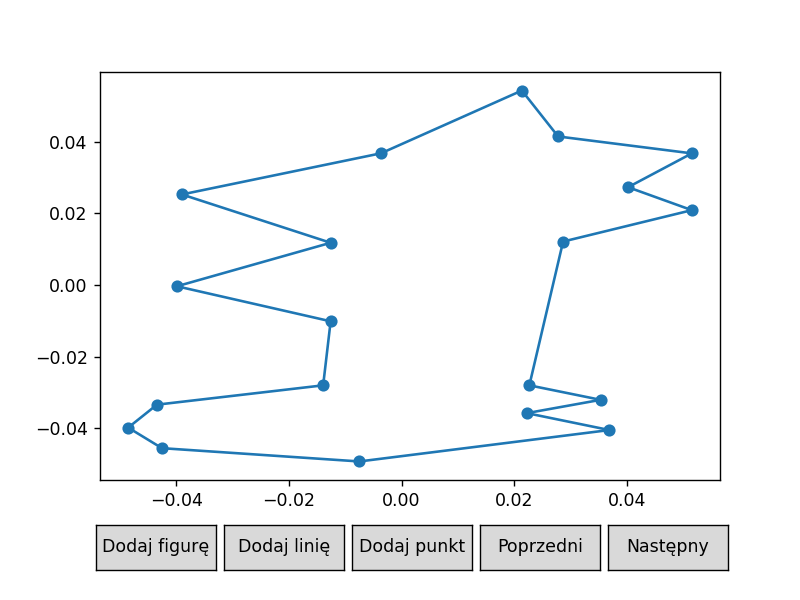

In [22]:
points1, lines1 = read_from_lines_file('plot1.json')
plot1 = Plot(points = [PointsCollection(points1)], lines= [LinesCollection(lines1)])
plot1.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [23]:
is_y_monotonic(points1)

True

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


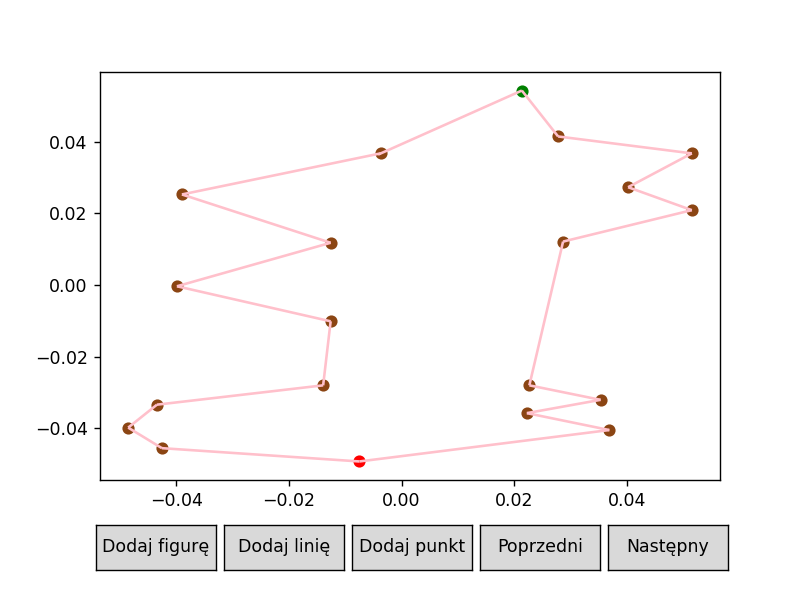

In [24]:
classified1 = classify(points1)
color_classified_points(classified1, lines1)

### Triangulacja

<IPython.core.display.Javascript object>


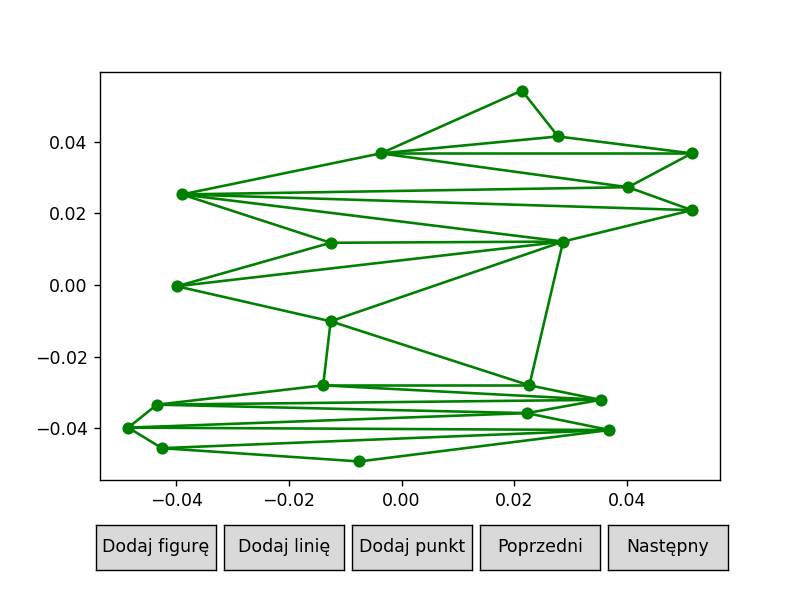

In [49]:
result = triangulate(points1,lines1)
plot = Plot(scenes= result[1])
plot.draw()

### ZESTAW 2

<IPython.core.display.Javascript object>


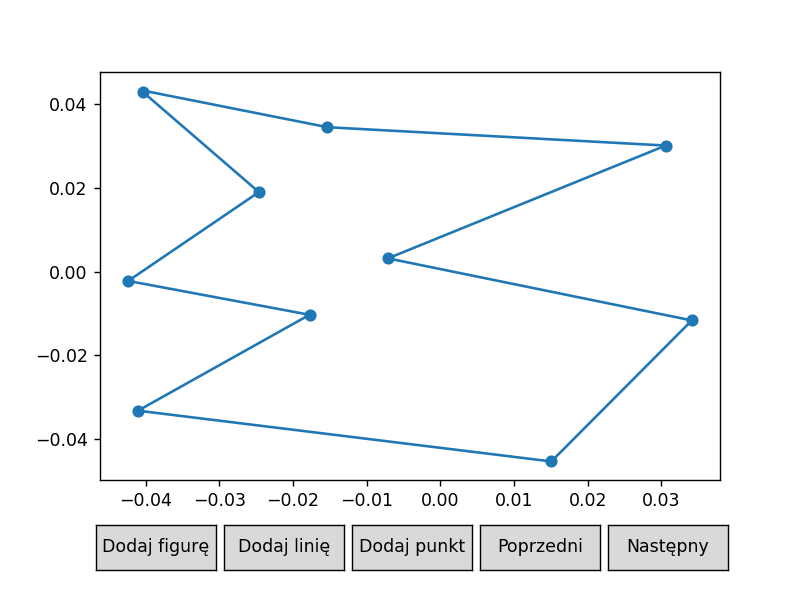

In [26]:
points2, lines2 = read_from_lines_file('plot2.json')
plot2 = Plot(points = [PointsCollection(points2)], lines= [LinesCollection(lines2)])
plot2.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [27]:
is_y_monotonic(points2)

True

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


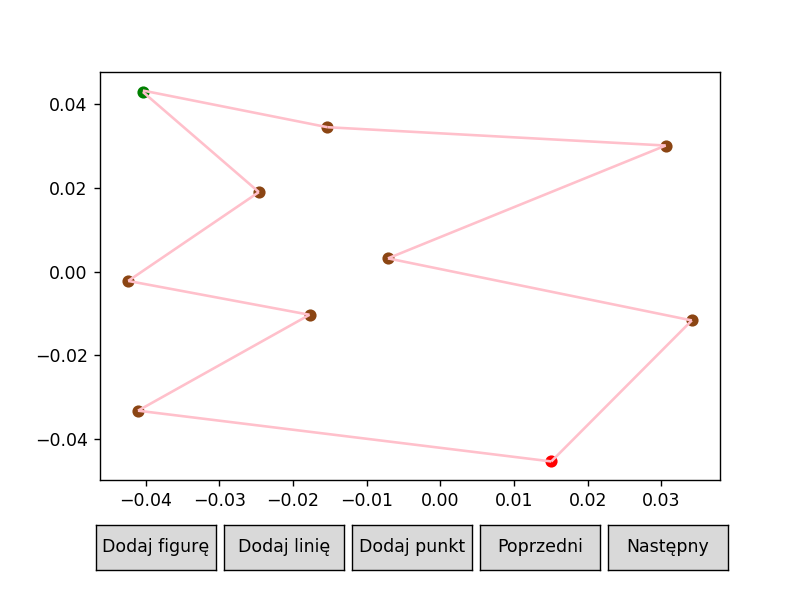

In [28]:
classified2 = classify(points2)
color_classified_points(classified2, lines2)

### Triangulacja

<IPython.core.display.Javascript object>


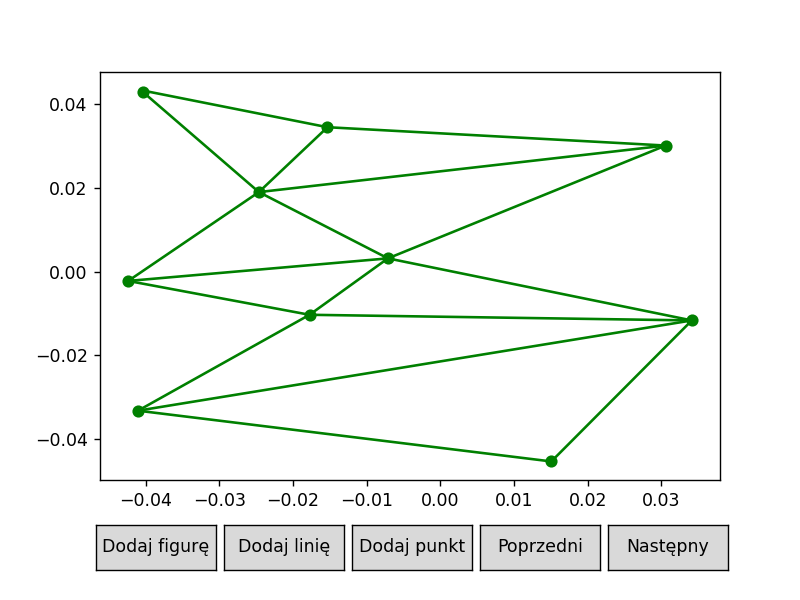

In [50]:
result = triangulate(points2,lines2)
plot = Plot(scenes= result[1])
plot.draw()

### ZESTAW 3

<IPython.core.display.Javascript object>


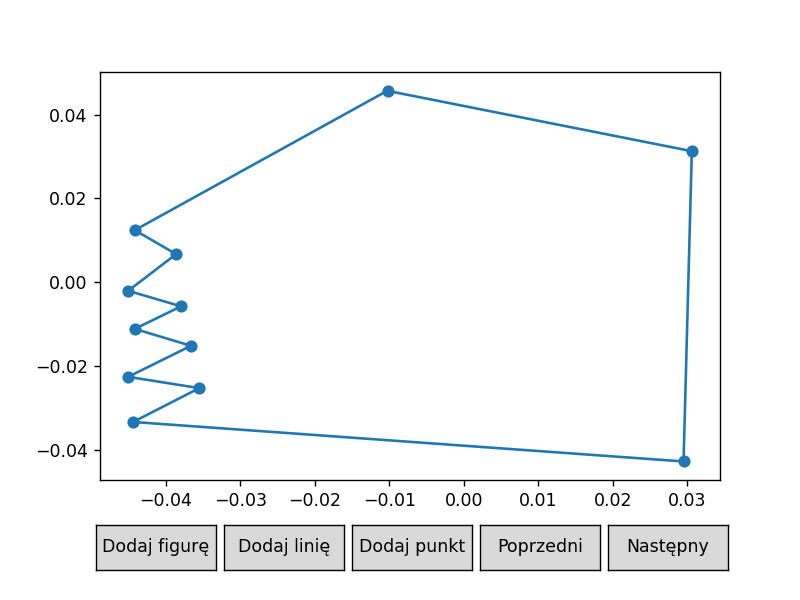

In [30]:
points3, lines3 = read_from_lines_file('plot3.json')
plot3 = Plot(points = [PointsCollection(points3)], lines= [LinesCollection(lines3)])
plot3.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [31]:
is_y_monotonic(points3)

True

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


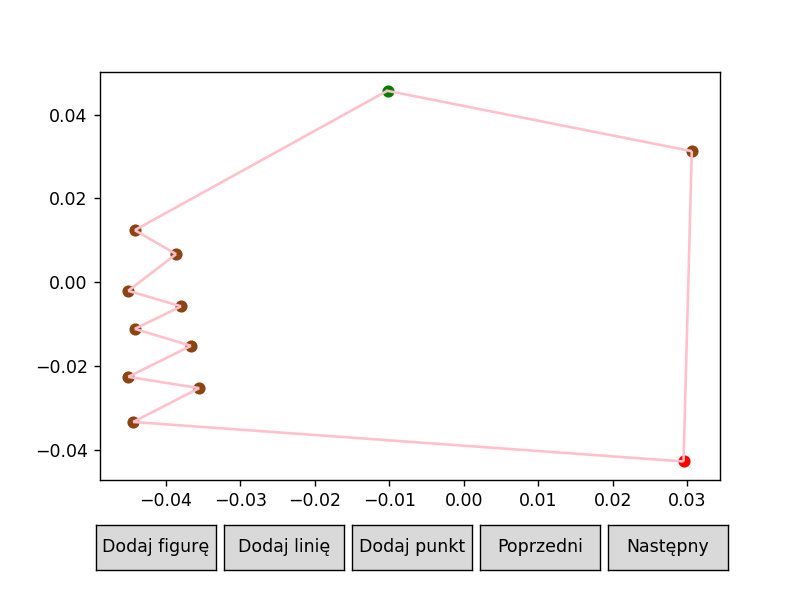

In [32]:
classified3 = classify(points3)
color_classified_points(classified3, lines3)

### Triangulacja

<IPython.core.display.Javascript object>


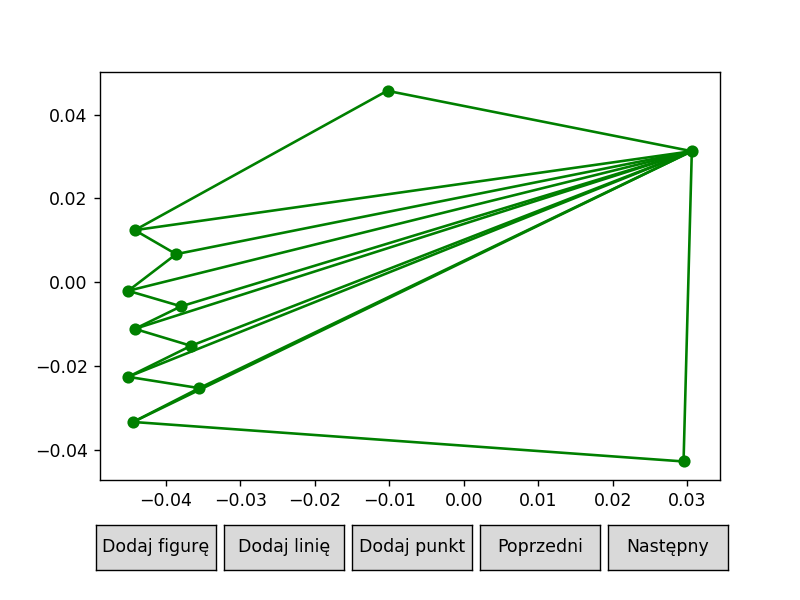

In [51]:
result = triangulate(points3,lines3)
plot = Plot(scenes= result[1])
plot.draw()

### ZESTAW 4

<IPython.core.display.Javascript object>


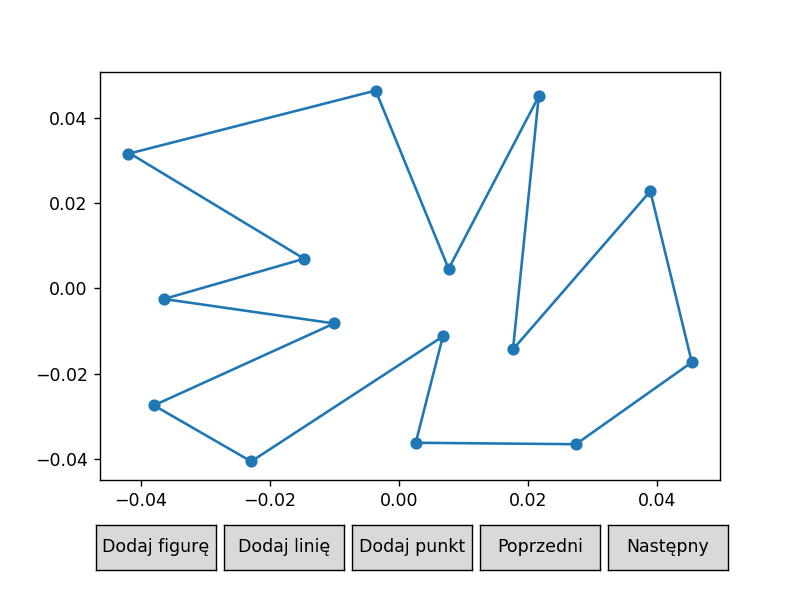

In [34]:
points4, lines4 = read_from_lines_file('plot4.json')
plot4 = Plot(points = [PointsCollection(points4)], lines= [LinesCollection(lines4)])
plot4.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [35]:
is_y_monotonic(points4)

False

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


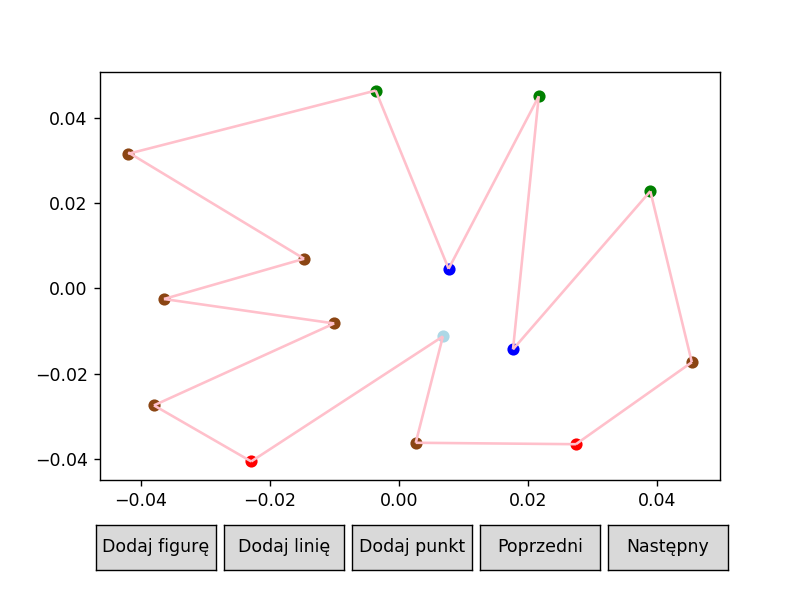

In [36]:
classified4 = classify(points4)
color_classified_points(classified4, lines4)

### Triangulacja

In [37]:
result = triangulate(points4,lines4)

it is not a monotonic figure!


### ZESTAW 5

<IPython.core.display.Javascript object>


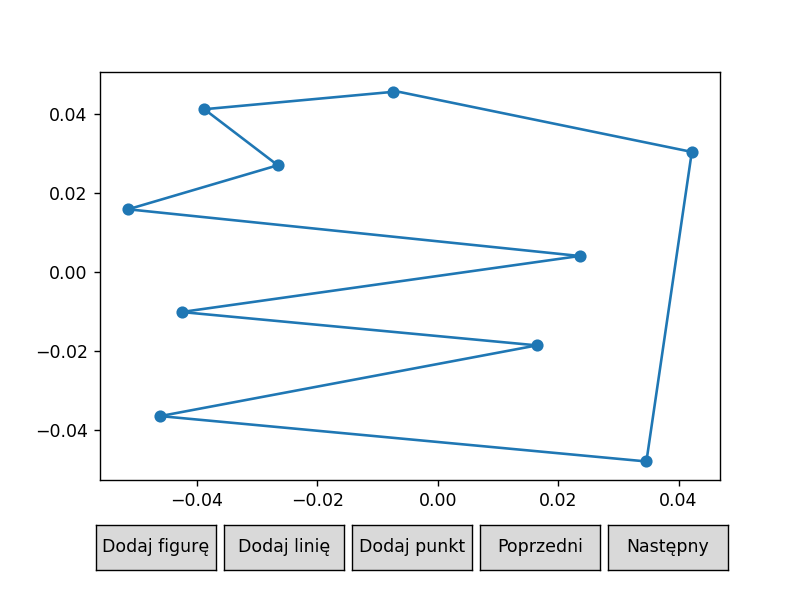

In [38]:
points5, lines5 = read_from_lines_file('plot5.json')
plot5 = Plot(points = [PointsCollection(points5)], lines= [LinesCollection(lines5)])
plot5.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [39]:
is_y_monotonic(points5)

True

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


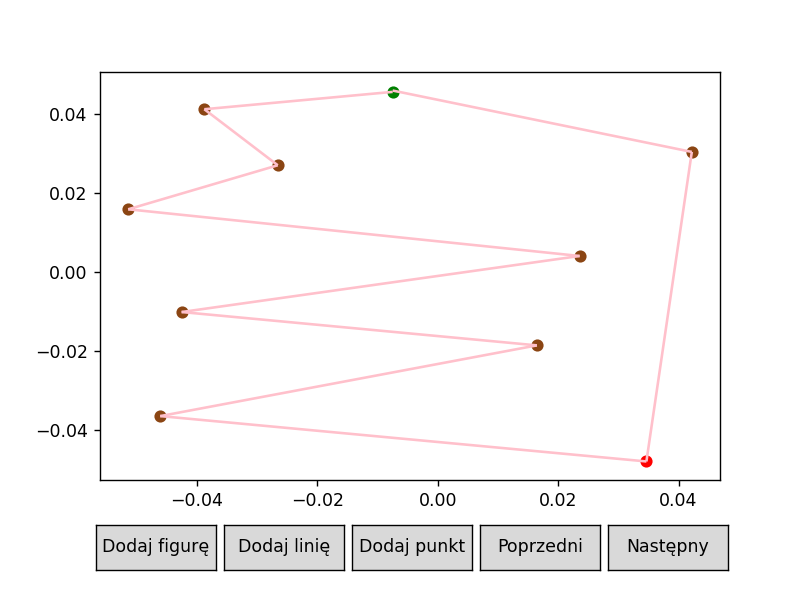

In [40]:
classified5 = classify(points5)
color_classified_points(classified5, lines5)

### Triangulacja

<IPython.core.display.Javascript object>


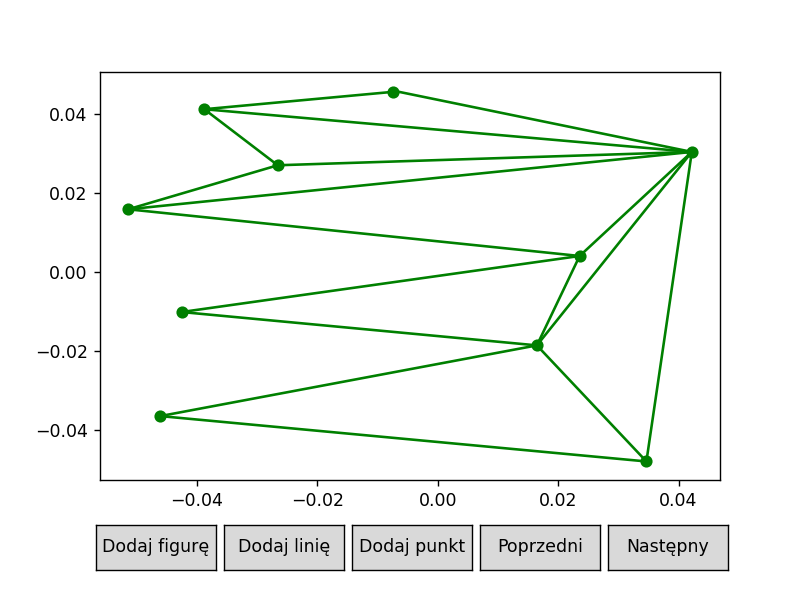

In [52]:
result = triangulate(points5,lines5)
plot = Plot(scenes= result[1])
plot.draw()

### ZESTAW 6

<IPython.core.display.Javascript object>


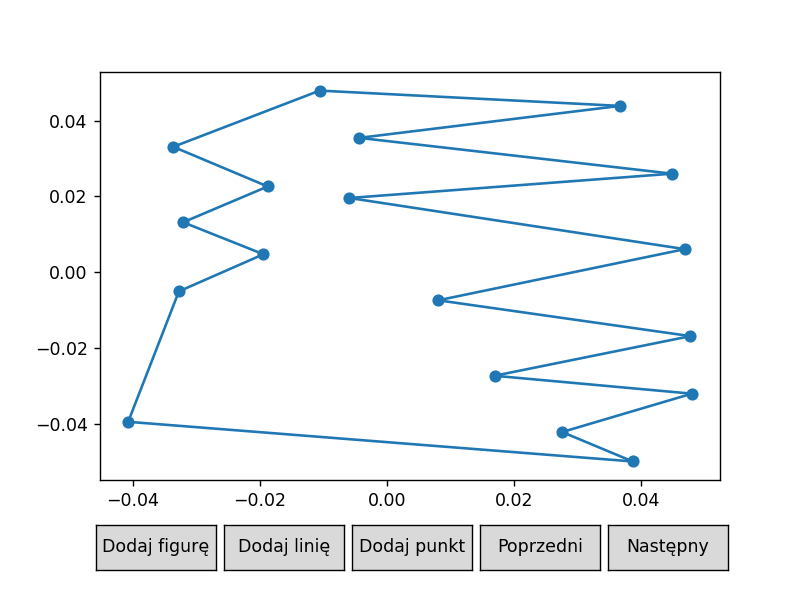

In [42]:
points6, lines6 = read_from_lines_file('plot6.json')
plot6 = Plot(points = [PointsCollection(points6)], lines= [LinesCollection(lines6)])
plot6.draw()

### Sprawdzenie czy wielokąt jest monotoniczny

In [43]:
is_y_monotonic(points6)

True

### Klasyfikacja punktów

<IPython.core.display.Javascript object>


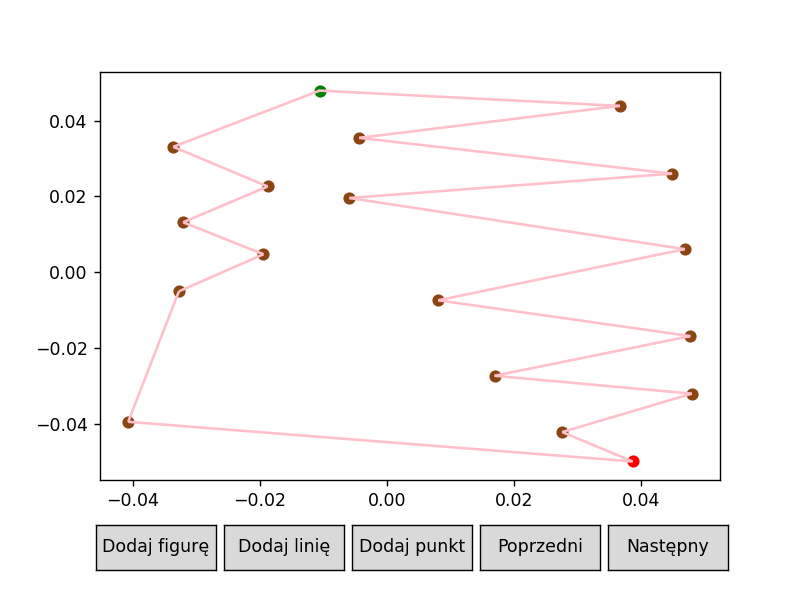

In [44]:
classified6 = classify(points6)
color_classified_points(classified6, lines6)

### Triangulacja

<IPython.core.display.Javascript object>


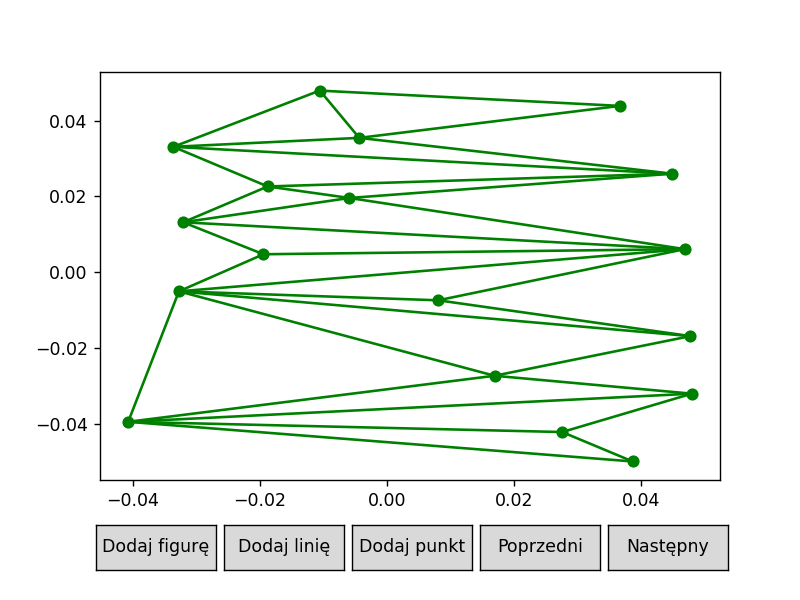

In [45]:
result = triangulate(points6,lines6)
plot = Plot(scenes= result[1])
plot.draw()

### WŁASNE RYSOWANIE

<IPython.core.display.Javascript object>


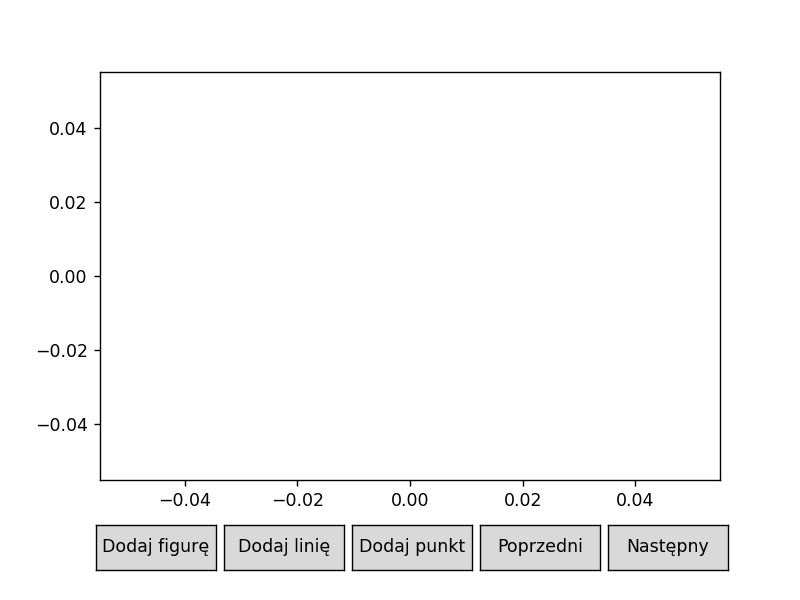

In [46]:
plot = Plot(points = [PointsCollection([])])
plot.draw()

In [47]:
lines = plot_to_lines(plot)
points = lines_to_points(lines)
classified = classify(points)
color_classified_points(classified, lines)

IndexError: list index out of range

<IPython.core.display.Javascript object>


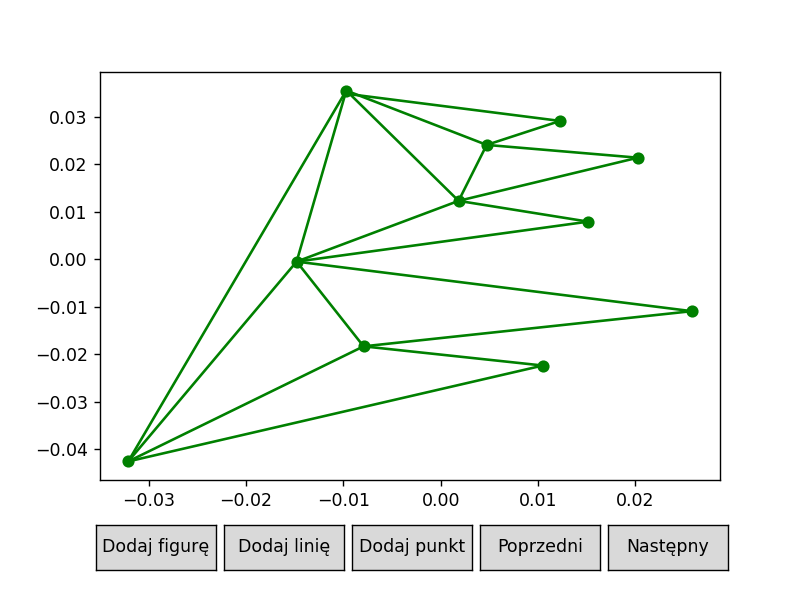

8


In [71]:
result = triangulate(points,lines)
plot = Plot(scenes= result[1])
plot.draw()
print(result[2])

<IPython.core.display.Javascript object>


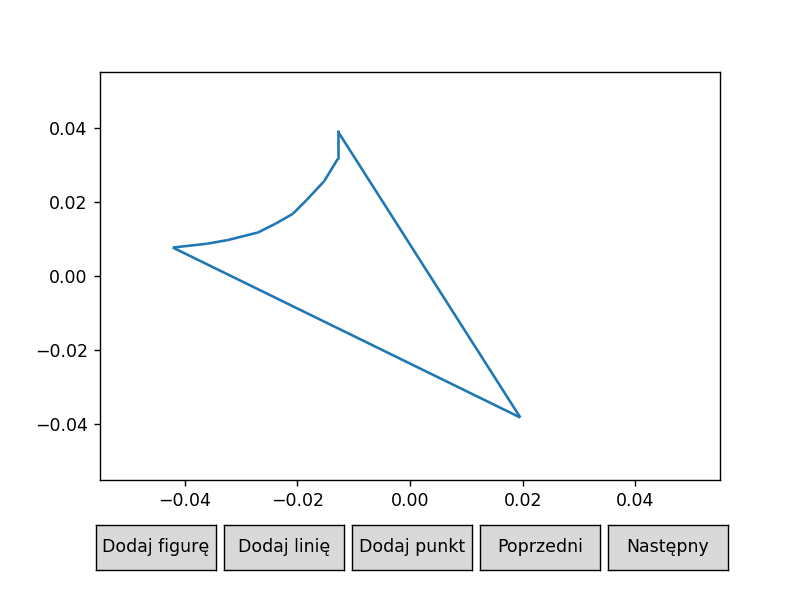

In [24]:
plot2 = Plot(points = [PointsCollection([])])
plot2.draw()

<IPython.core.display.Javascript object>


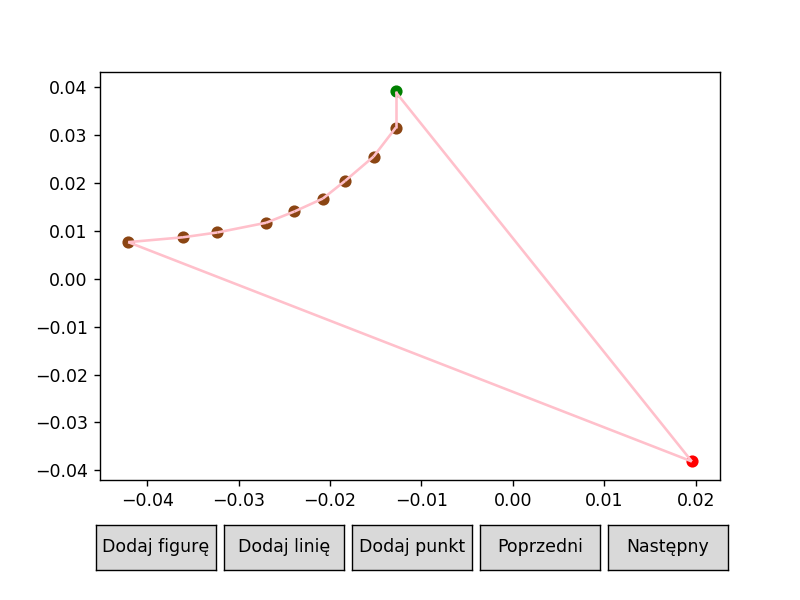

In [25]:
lines2 = plot_to_lines(plot2)
points2 = lines_to_points(lines2)
classified2 = classify(points2)
color_classified_points(classified2, lines2)

<IPython.core.display.Javascript object>


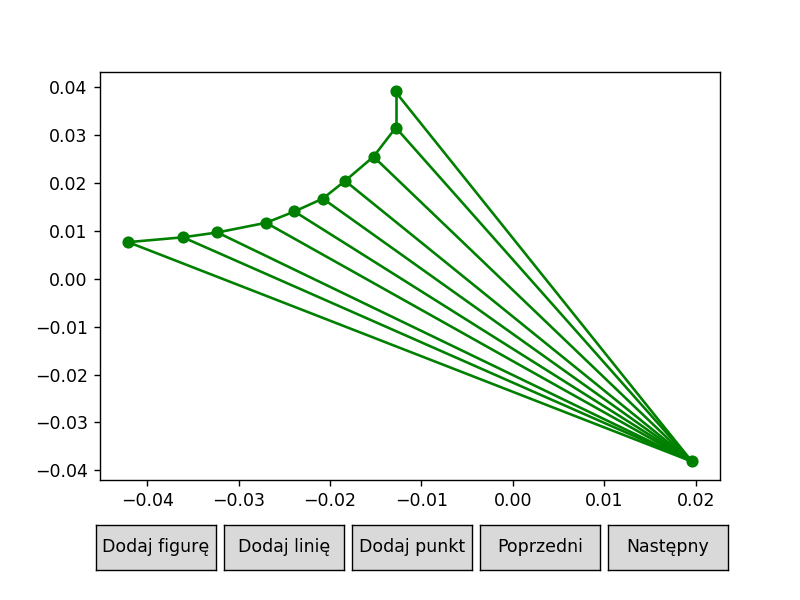

8


In [70]:
result = triangulate(points2,lines2)
plot = Plot(scenes= result[1])
plot.draw()
print(result[2])